# Libraries

In [1]:
import numpy as np
import pandas as pd
import pathlib, glob, math
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, explained_variance_score

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.multioutput import RegressorChain
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBRFRegressor

# Data Preprocessing

In [2]:
data_dir = "PV"

In [3]:
data_dir = pathlib.Path(data_dir)
folder = list(data_dir.glob('*'))
print('Folder Structure:')
for f in folder:
    print(f)

Folder Structure:
PV\2_Feb_SFV_63176617_2016.xlsx
PV\3_Mar_SFV_63176617_2016.xlsx
PV\4_Apr_SFV_63176617_2016.xlsx
PV\5_May_SFV_63176617_2016.xlsx
PV\6_Jun_SFV_63176617_2016.xlsx
PV\7_Jul_SFV_63176617_2016.xlsx


In [4]:
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
datosPV = pd.DataFrame()
for f in sorted(glob.glob(str(data_dir)+"/*.xlsx")):
  df = pd.read_excel(f, header=0)
  datosPV = pd.concat([datosPV,df], axis=0, sort=False, ignore_index=True)
datosPV = datosPV.dropna(axis=1)
datosPV = datosPV.drop(range(0, 960, 1),axis=0).reset_index(drop=True)
datosPV = datosPV.drop(labels=['MEDIDOR','KWHR','KVARHD','FECHA','INTERVALO'],axis=1)
rng = pd.date_range(start = '2016-02-11 00:00', end ='2016-07-31 23:45', freq='15min')
datosPV = datosPV.set_index(rng)
print(datosPV.shape)
datosPV.head(5)

(16512, 1)


,KWHD
2016-02-11 00:00:00,0.0
2016-02-11 00:15:00,0.0
2016-02-11 00:30:00,0.0
2016-02-11 00:45:00,0.0
2016-02-11 01:00:00,0.0


In [5]:
fin_train = '2016-06-10 09:45:00'
fin_validacion = '2016-07-14 19:15:00'

datosPV_train = datosPV.loc[: fin_validacion, :] 
datosPV_test = datosPV.loc[fin_validacion:, :]

train_size = datosPV_train.shape[0]
test_size = datosPV_test.shape[0]

print(f"Fechas train      : {datosPV_train.index.min()} --- {datosPV_train.index.max()}")
print(f"Fechas test       : {datosPV_test.index.min()} --- {datosPV_test.index.max()}")

Fechas train      : 2016-02-11 00:00:00 --- 2016-07-14 19:15:00
Fechas test       : 2016-07-14 19:15:00 --- 2016-07-31 23:45:00


In [6]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))*(100)

## Data conversion to forecasting windows

In [7]:
def convert_dataTS(train,test,lag,window):
    train = np.array(train)
    test = np.array(test)
    X_train, y_train = [], []
    X_test, y_test = [], []

    for i in range(lag, len(train)-lag):
        X_train.append(train[i-lag:i])
        y_train.append(train[i:i+window])

    for i in range(lag, len(test)-lag):
        X_test.append(test[i-lag:i])
        y_test.append(test[i:i+window])
    
    X_train,X_test,y_train,y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 
    return X_train,X_test,y_train,y_test
    

In [8]:
X_train_15,X_test_15,y_train_15,y_test_15 =  convert_dataTS(datosPV_train.KWHD,datosPV_test.KWHD,96,1)
print(X_train_15.shape, X_test_15.shape)
X_train_30,X_test_30,y_train_30,y_test_30 =  convert_dataTS(datosPV_train.KWHD,datosPV_test.KWHD,96,2)
print(X_train_30.shape, X_test_30.shape) 
X_train_60,X_test_60,y_train_60,y_test_60 =  convert_dataTS(datosPV_train.KWHD,datosPV_test.KWHD,96,4)
print(X_train_60.shape, X_test_60.shape) 

(14670, 96) (1459, 96)
(14670, 96) (1459, 96)
(14670, 96) (1459, 96)


# ML models

## XGB

### 15 mins ahead

In [9]:
model_XGB = RegressorChain(XGBRegressor(random_state=1, max_depth = 10, n_estimators=600, learning_rate=0.15,  n_jobs = -1))

In [10]:
model_XGB.fit(X_train_15,y_train_15)
predictionsXGB = model_XGB.predict(X_test_15)

In [11]:
MAPE1 = MAPE(y_test_15, predictionsXGB)
print("MSE:", mean_squared_error(y_test_15, predictionsXGB))
print("RMSE:", math.sqrt(mean_squared_error(y_test_15, predictionsXGB)))
print("MAE:",mean_absolute_error(y_test_15, predictionsXGB))
print("R2:", r2_score(y_test_15, predictionsXGB))
print("Explained Variance:", explained_variance_score(y_test_15, predictionsXGB))
print("Mean Absolute Percentage Error:",MAPE1)

MSE: 0.0006914321806359537
RMSE: 0.026295098034347653
MAE: 0.013109873242676621
R2: 0.9021421354053611
Explained Variance: 0.9023451238707162
Mean Absolute Percentage Error: 14.389695011508113


### 30 min ahead

In [12]:
model_XGB.fit(X_train_30,y_train_30)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.15, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=10,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=1, ...))

In [13]:
predictionsXGB2 = model_XGB.predict(X_test_30)
MAPE_MLP1 = MAPE(y_test_30[:,0], predictionsXGB2[:,0])
MAPE_MLP2 = MAPE(y_test_30[:,1], predictionsXGB2[:,1])
print("MSE:", mean_squared_error(y_test_30, predictionsXGB2))
print("RMSE:", math.sqrt(mean_squared_error(y_test_30, predictionsXGB2)))
print("MAE:",mean_absolute_error(y_test_30, predictionsXGB2))
print("R2:", r2_score(y_test_30, predictionsXGB2))
print("Explained Variance:", explained_variance_score(y_test_30, predictionsXGB2))
print("Mean Absolute Percentage Error MLP:",(MAPE_MLP1+MAPE_MLP2)/2)

MSE: 0.0008210444663954023
RMSE: 0.028653873497232488
MAE: 0.014471330501926068
R2: 0.8837982083148042
Explained Variance: 0.8843747443536426
Mean Absolute Percentage Error MLP: 17.41149240355029


### 1 hour ahead

In [14]:
model_XGB.fit(X_train_60,y_train_60)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.15, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=10,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=1, ...))

In [15]:
predictionsXGB3 = model_XGB.predict(X_test_60)
MAPE1 = MAPE(y_test_60[:,0], predictionsXGB3[:,0])
MAPE2 = MAPE(y_test_60[:,1], predictionsXGB3[:,1])
MAPE3 = MAPE(y_test_60[:,2], predictionsXGB3[:,2])
MAPE4 = MAPE(y_test_60[:,3], predictionsXGB3[:,3])
print("MSE:", mean_squared_error(y_test_60, predictionsXGB3))
print("RMSE:", math.sqrt(mean_squared_error(y_test_60, predictionsXGB3)))
print("MAE:",mean_absolute_error(y_test_60, predictionsXGB3))
print("R2:", r2_score(y_test_60, predictionsXGB3))
print("Explained Variance:", explained_variance_score(y_test_60, predictionsXGB3))
print("Mean Absolute Percentage Error MLP:",(MAPE1+MAPE2+MAPE3+MAPE4)/4)

MSE: 0.0009446787361637862
RMSE: 0.03073562649701135
MAE: 0.015728716448636125
R2: 0.8663003452284723
Explained Variance: 0.8673707489125878
Mean Absolute Percentage Error MLP: 20.209161054283953


## SVR

### 15 mins ahead

In [16]:
model_SVR = RegressorChain(SVR(C=0.065, epsilon=0.01, kernel="rbf"))

In [17]:
model_SVR.fit(X_train_15,y_train_15)
predictionsSVR = model_SVR.predict(X_test_15)

In [18]:
MAPE1 = MAPE(y_test_15, predictionsSVR)
print("MSE:", mean_squared_error(y_test_15, predictionsSVR))
print("RMSE:", math.sqrt(mean_squared_error(y_test_15, predictionsSVR)))
print("MAE:",mean_absolute_error(y_test_15, predictionsSVR))
print("R2:", r2_score(y_test_15, predictionsSVR))
print("Explained Variance:", explained_variance_score(y_test_15, predictionsSVR))
print("Mean Absolute Percentage Error MLP:",MAPE1)

MSE: 0.0006964225750348326
RMSE: 0.02638981953395727
MAE: 0.014282487200424928
R2: 0.9014358487252848
Explained Variance: 0.9014466137916407
Mean Absolute Percentage Error MLP: 18.867948891216017


### 30 min ahead

In [19]:
model_SVR.fit(X_train_30,y_train_30)

RegressorChain(base_estimator=SVR(C=0.065, epsilon=0.01))

In [20]:
predictionsSVR2 = model_SVR.predict(X_test_30)
MAPE1 = MAPE(y_test_30[:,0], predictionsSVR2[:,0])
MAPE2 = MAPE(y_test_30[:,1], predictionsSVR2[:,1])
print("MSE:", mean_squared_error(y_test_30, predictionsSVR2))
print("RMSE:", math.sqrt(mean_squared_error(y_test_30, predictionsSVR2)))
print("MAE:",mean_absolute_error(y_test_30, predictionsSVR2))
print("R2:", r2_score(y_test_30, predictionsSVR2))
print("Explained Variance:", explained_variance_score(y_test_30, predictionsSVR2))
print("Mean Absolute Percentage Error MLP:",(MAPE1+MAPE2)/2)

MSE: 0.000831982438788657
RMSE: 0.02884410578937501
MAE: 0.015894174653200747
R2: 0.8822501654967586
Explained Variance: 0.8822592896943064
Mean Absolute Percentage Error MLP: 21.988460606110188


### 1 hour ahead

In [21]:
model_SVR.fit(X_train_60,y_train_60)

RegressorChain(base_estimator=SVR(C=0.065, epsilon=0.01))

In [22]:
predictionsSVR3 = model_SVR.predict(X_test_60)
MAPE1 = MAPE(y_test_60[:,0], predictionsSVR3[:,0])
MAPE2 = MAPE(y_test_60[:,1], predictionsSVR3[:,1])
MAPE3 = MAPE(y_test_60[:,2], predictionsSVR3[:,2])
MAPE4 = MAPE(y_test_60[:,3], predictionsSVR3[:,3])
print("MSE:", mean_squared_error(y_test_60, predictionsSVR3))
print("RMSE:", math.sqrt(mean_squared_error(y_test_60, predictionsSVR3)))
print("MAE:",mean_absolute_error(y_test_60, predictionsSVR3))
print("R2:", r2_score(y_test_60, predictionsSVR3))
print("Explained Variance:", explained_variance_score(y_test_60, predictionsSVR3))
print("Mean Absolute Percentage Error:",(MAPE1+MAPE2+MAPE3+MAPE4)/4)

MSE: 0.0010121268391533422
RMSE: 0.031813940956023384
MAE: 0.01790589088786486
R2: 0.8567544671013556
Explained Variance: 0.8567599447885471
Mean Absolute Percentage Error: 25.700703013807498


## Random Forest

### 15 min ahead

In [23]:
model_RF = RegressorChain(XGBRFRegressor(n_estimators=600, max_depth=6, n_jobs = -1))

In [24]:
model_RF.fit(X_train_15,y_train_15)
predictionsRF = model_RF.predict(X_test_15)

In [25]:
MAPE1 = MAPE(y_test_15[:,0], predictionsRF[:,0])
print("MSE:", mean_squared_error(y_test_15, predictionsRF))
print("RMSE:", math.sqrt(mean_squared_error(y_test_15, predictionsRF)))
print("MAE:",mean_absolute_error(y_test_15, predictionsRF))
print("R2:", r2_score(y_test_15, predictionsRF))
print("Explained Variance:", explained_variance_score(y_test_15, predictionsRF))
print("Mean Absolute Percentage Error:",MAPE1)

MSE: 0.0006328766325692346
RMSE: 0.02515703942377232
MAE: 0.012139269103705271
R2: 0.9104294570754453
Explained Variance: 0.9106820159262868
Mean Absolute Percentage Error: 14.491684041059216


### 30 min ahead

In [26]:
model_RF.fit(X_train_30,y_train_30)
predictionsRF2 = model_RF.predict(X_test_30)

In [27]:
MAPE1 = MAPE(y_test_30[:,0], predictionsRF2[:,0])
MAPE2 = MAPE(y_test_30[:,1], predictionsRF2[:,1])
print("MSE:", mean_squared_error(y_test_30, predictionsRF2))
print("RMSE:", math.sqrt(mean_squared_error(y_test_30, predictionsRF2)))
print("MAE:",mean_absolute_error(y_test_30, predictionsRF2))
print("R2:", r2_score(y_test_30, predictionsRF2))
print("Explained Variance:", explained_variance_score(y_test_30, predictionsRF2))
print("Mean Absolute Percentage Error MLP:",(MAPE1+MAPE2)/2)

MSE: 0.0007504643579842197
RMSE: 0.02739460454148261
MAE: 0.01344053875669809
R2: 0.8937873567597374
Explained Variance: 0.8944353146220834
Mean Absolute Percentage Error MLP: 16.91994717443821


### 1 hour ahead

In [28]:
model_RF.fit(X_train_60,y_train_60)
predictionsRF3 = model_RF.predict(X_test_60)

In [29]:
MAPE1 = MAPE(y_test_60[:,0], predictionsRF3[:,0])
MAPE2 = MAPE(y_test_60[:,1], predictionsRF3[:,1])
MAPE3 = MAPE(y_test_60[:,2], predictionsRF3[:,2])
MAPE4 = MAPE(y_test_60[:,3], predictionsRF3[:,3])
print("MSE:", mean_squared_error(y_test_60, predictionsRF3))
print("RMSE:", math.sqrt(mean_squared_error(y_test_60, predictionsRF3)))
print("MAE:",mean_absolute_error(y_test_60, predictionsRF3))
print("R2:", r2_score(y_test_60, predictionsRF3))
print("Explained Variance:", explained_variance_score(y_test_60, predictionsRF3))
print("Mean Absolute Percentage Error MLP:",(MAPE1+MAPE2+MAPE3+MAPE4)/4)

MSE: 0.0008756216592817383
RMSE: 0.029590905009508214
MAE: 0.014862913748175211
R2: 0.8760739401927817
Explained Variance: 0.8776476171424598
Mean Absolute Percentage Error MLP: 19.674571660211157


# Comparison

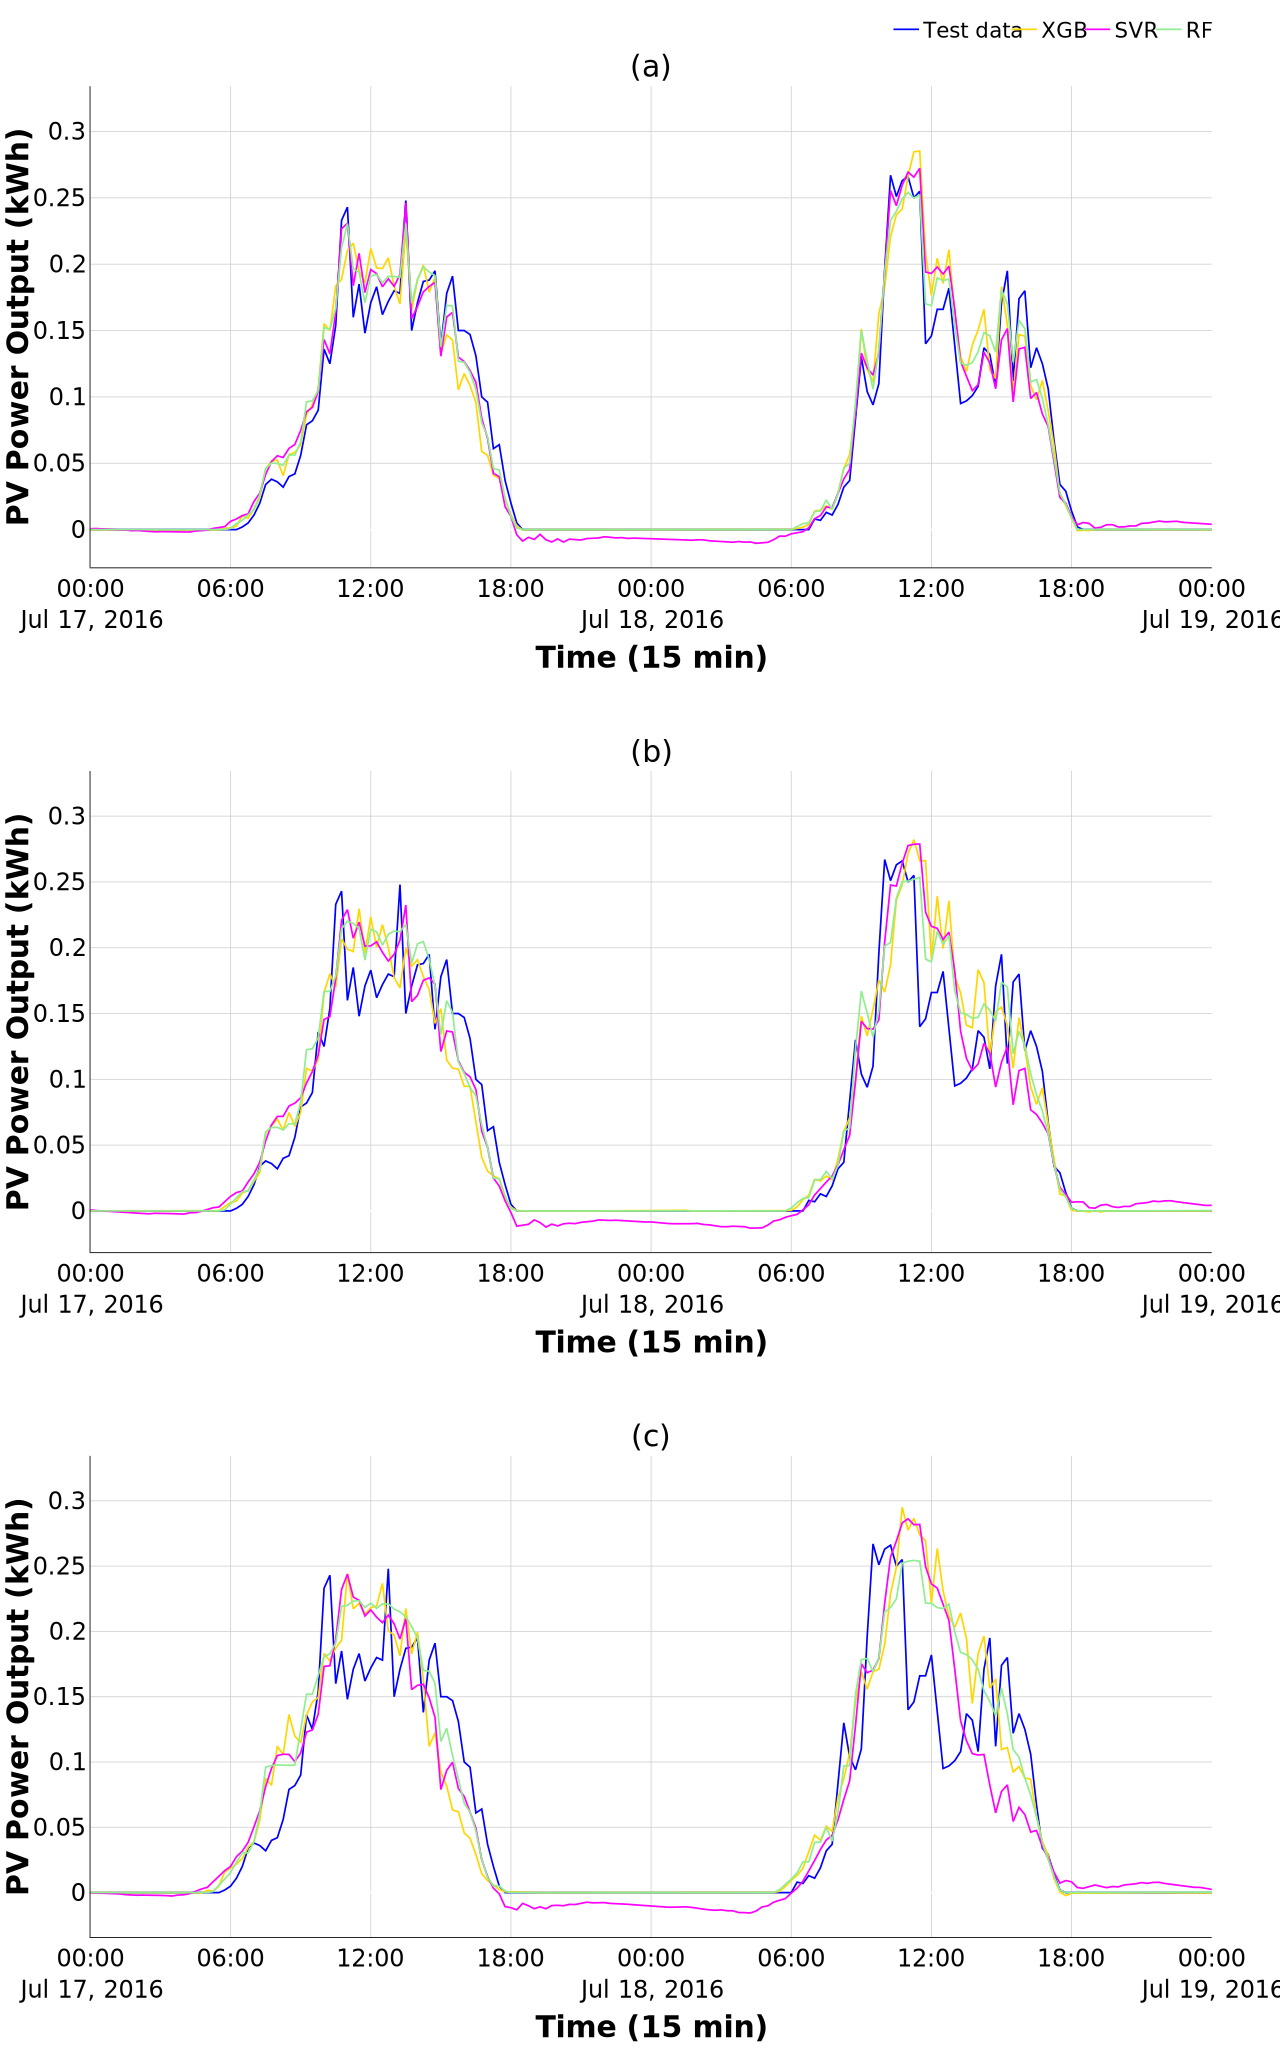

In [30]:
figPVCom2 = make_subplots(rows=3, cols=1, vertical_spacing = 0.11, subplot_titles=['(a)','(b)','(c)'])


figPVCom2.append_trace(go.Scatter(y=datosPV_test.KWHD[95:,], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data"), row=1, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsXGB[:,0], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="XGB"), row=1, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsSVR[:,0], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="fuchsia"),
                                 name="SVR"), row=1, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsRF[:,0], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="lightgreen"),
                                 name="RF"), row=1, col=1)


figPVCom2.append_trace(go.Scatter(y=datosPV_test.KWHD[96:,], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False), row=2, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsXGB2[:,1], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="XGB", showlegend=False), row=2, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsSVR2[:,1], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="fuchsia"),
                                 name="SVR", showlegend=False), row=2, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsRF2[:,1], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="lightgreen"),
                                 name="RF", showlegend=False), row=2, col=1)



figPVCom2.append_trace(go.Scatter(y=datosPV_test.KWHD[98:,], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False), row=3, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsXGB3[:,3], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="XGB", showlegend=False), row=3, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsSVR3[:,3], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="fuchsia"),
                                 name="SVR", showlegend=False), row=3, col=1)
figPVCom2.append_trace(go.Scatter(y=predictionsRF3[:,3], x=datosPV_test.index,
                                 mode='lines', line=dict(width=2, color="lightgreen"),
                                 name="RF", showlegend=False), row=3, col=1)



figPVCom2.update_layout(title='',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=1500,height=2400,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      font=dict(family="Fira Sans, Condensed", color='black'),
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=25, font_color='black'),
                      showlegend=True)
figPVCom2.update_xaxes(range=['2016-07-17 00:00:00','2016-07-19 00:00:00'])    
figPVCom2.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Time (15 min)</b>', titlefont_size=35, tickfont_size=28)
figPVCom2.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>PV Power Output (kWh)</b>', titlefont_size=35, tickfont_size=28)
figPVCom2.update_annotations(font=dict(size=35))
figPVCom2.show("svg")